# Clustering
The following implements the k-means and GMM algorithms from scratch. This is note a task to complete, but please use it to augment your understanding of the notes and methods beyond the implemented APIs we use in the lab. 

The implementations in sklearn do provide additional functionality, however the below implementations should let you have a deeper understanding of the methods.

Also note that this implementation may not be the most efficient, but it should hopefully be readable and intuitive.

In [1]:
import numpy as np
import matplotlib.pyplot as plt   

In [2]:
data = np.load('./Iris_data.npy')
labels = np.load('./Iris_labels.npy')

# Choose two features dimensions to plot, keeping it consistent for the notebook
x_feature = 0
y_feature = 1

## K-means Clustering 
The task here is to implement the k-means algorithm. We first define a function to calculate the Euclidean distance between each of the cluster centres and the data, then we initialise our hyper-parameters and create a loop to fit our clusters to the data, iteratively calling the assignment and update operations.

### K-Means algorithm:

Setup: Select random initial set of k cluster centers

Loop:

    for i = 1 to maximum number of iterations
        calculate distance from training points to cluster centroids
        update class labels to the closest centroid's ID
        recalculate centroid locations

In [3]:
# Definition of euclidean distance function
def euclidean_distance(centroids, datapoints):
    '''Compute the Euclidean distance between datapoints and centroids.
    
    Keyword arguments:
    centroids -- KxF matrix, cluster centroids (K centroids, F dimensions)
    datapoints -- NxF matrix, data points observed (N samples, F dimensions)
    
    Returns:
    dists -- NxK matrix, distances from sample N_i to cluster K_i
    '''
    
    n_samples = datapoints.shape[0]
    n_features = datapoints.shape[1]
    n_centroids = centroids.shape[0]
    
    dists = np.zeros(shape=[n_samples, n_centroids])
    for k in range(n_centroids):
        differences = datapoints - centroids[k, :]
        sum_of_squared_differences = np.zeros(n_samples)
        for i_dimension in range(n_features):
            sum_of_squared_differences += differences[:, i_dimension]**2
        dists[:, k] = np.sqrt(sum_of_squared_differences)
        
    return dists


# Definition of k-Means algorithm
def k_means(data, k, n_iteration=10, verbose=None):
    '''Apply the k-means algorithm to cluster the input data into k clusters.
    
    Keyword arguments:
    data -- NxF matrix, the data to cluster (N samples, F dimensions)
    k -- scalar int, the number of clusters to generate
    n_iteration -- scalar int, the maximum number of iterations to carry out
    verbose -- choice of {None, 'print', 'plot'}, whether to output details of each iteration


    Returns:
    predicted_labels -- Nx1 vector, predicted cluster IDs based on k-means model (N samples) 
    centroids -- KxF matrix, cluster center locations (K clusters, F dimensions)
    '''
    
    n_samples = data.shape[0]
    n_features = data.shape[1]
    
    # Initialize centroids by randomly selecting k points. Can we do this another way?
    centroids = data[np.random.choice(n_samples, k, replace=False), :] 
    
    i = 0
    early_stop = False
    early_stop_tolerance = 1e-5
    while i < n_iteration and not early_stop:
        prev_centroids = centroids
        
        # Assignment step
        dists = euclidean_distance(centroids, data)
        predicted_labels = np.argmin(dists, axis=1)

        # Update step
        new_centroids = np.zeros(shape=[k, n_features])
        
        for i_cluster in range(k):
            # Get all datapoints alocated to cluster i_k
            cluster_data = data[predicted_labels == i_cluster, :]
            # Calculate the mean of this cluster
            new_centroids[i_cluster, :] = np.mean(cluster_data, axis=0)
            
        centroids = new_centroids
        update_distance = np.sum(np.abs(centroids - prev_centroids))

        # Verbose printing
        if verbose == 'print':
            print(f'Iteration {i}: update distance = {update_distance}')
        elif verbose == 'plot':
            plt.figure()
            plt.scatter(data[:, x_feature], data[:, y_feature], c=predicted_label)
            plt.scatter(centroids[:, x_feature], centroids[:, y_feature], marker='x', s=50)
            plt.title(f'k-Means Iteration {i}, Update dist: {update_distance}')
            plt.show()
                
        # Early stopping
        if update_distance < early_stop_tolerance:
            print(f'Early stop on iteration {i}')
            early_stop = True
        
        i += 1

    # One final assignment to get final predictions
    predicted_labels = np.argmin(euclidean_distance(centroids, data), axis=1)
    
    return predicted_labels, centroids

Iteration 0: update distance = 5.11245390070922
Iteration 1: update distance = 0.660687522204241
Iteration 2: update distance = 0.652660743772674
Iteration 3: update distance = 0.1526091269841267
Iteration 4: update distance = 0.05151646068984819
Iteration 5: update distance = 0.0
Early stop on iteration 5


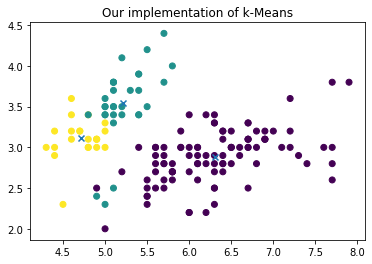

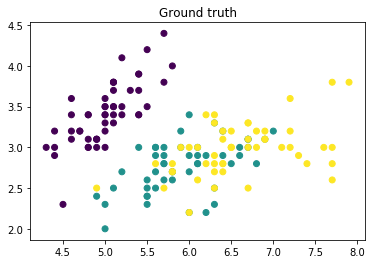

In [4]:
k = 3
n_iteration = 500

predicted_label, k_centroid = k_means(data, k, n_iteration, verbose='print')

# Visualisation of model predictions
plt.figure()
plt.scatter(data[:, x_feature], data[:, y_feature], c=predicted_label)
plt.scatter(k_centroid[:, x_feature], k_centroid[:, y_feature], marker='x')
plt.title('Our implementation of k-Means')
plt.show()

# Visualisation of ground truth
plt.figure()
plt.scatter(data[:, x_feature], data[:, y_feature], c=labels)
plt.title('Ground truth')
plt.show()

## Gaussian Mixture Models
The task here is to implement a Gaussian mixture model. We first define some functions for the algorithm, followed by initialisation of the parameters, and finally we implement the loop within which we fit our Gaussians to our data.

### GMM Algorithm:
Setup: Initialise Gaussian distribution centroid, standard deviations and mixing coefficients using k-means coefficients.

Loop: 

    Compute E-Step: calculate posteriors for the data given current Gaussian parameters 
    Compute M-Step: update model parameters 

In [5]:
# E-Step
def multivariate_gaussian_density(data, mu, cov):
    '''Apply the E-Step of the GMM algorithm. Calculating the multivariate Gaussian density of the data.
    
    Keyword arguments:
    data -- 1xF, data sample (F dimensions)
    mu -- 1xF vector, mean location of the Gaussian component (F dimensions)
    cov -- FxF matrix, the covariance matrix of the Gaussian component (F dimensions)
    
    Returns:
    result -- scalar, the Gaussian density function response (probability)
    '''
    
    n_sample = data.shape[0]
    
    determinant = np.linalg.det(cov)
    normalisation_factor = 1.0 / ((2 * np.pi)**(n_sample / 2) * determinant ** (1.0 / 2))
    mean_centred_data = data - mu
    inverse_covariance = np.linalg.inv(cov)
    result = np.e**(-(1.0 / 2) * (mean_centred_data @ inverse_covariance @ mean_centred_data.T))
    result = normalisation_factor * result
    
    return result


# Calculate the posterior probabilities per component for each datapoint
def posterior_prob(data, centroids, cov, mix):
    '''Calculate posterior probability for each Guassian component.
    
    Keyword arguments:
    data -- NxF matrix, data to cluster (N samples, F dimensions)
    centroids -- GxF matrix, current centroids (mu) of the Gaussian components (G components)
    cov -- FxFxG tensor, current covariance matrices (FxF) for each Gaussian component
    mix -- Gx1 vector, current mixing coefficients for each Gaussian component
    
    Returns:
    posteriors -- NxG matrix, posterior probability that each sample belongs to a Gaussian component (N samples, G components)
    '''
    
    n_sample = data.shape[0]
    n_component = centroids.shape[0]
    p = np.zeros([n_sample, n_component])
    p_total = np.zeros(n_sample)
    posteriors = np.zeros([n_sample, n_component])

    for i_sample in range(n_sample):
        for i_component in range(n_component):
            p[i_sample, i_component] = multivariate_gaussian_density(
                data[i_sample, :].T, centroids[i_component, :], cov[:, :, i_component])
            p_total[i_sample] = p_total[i_sample] + p[i_sample, i_component]

        for i_component in range(n_component):
            posteriors[i_sample, i_component] = (
                p[i_sample, i_component] * mix[i_component]) / (p_total[i_sample] * mix[i_component])
    
    return posteriors


# M-Step
def update_params(data, posteriors, mix, cov, centroids):
    '''Apply the M-Step of GMM algorithm. Updating the component parameters and assignments.
    
    Keyword arguments:
    data -- NxF matrix, data to cluster (N samples, F dimensions)
    posteriors -- NxG matrix, posterior probability that each sample belongs to a Gaussian component (N samples, G components)
    mix -- Gx1 vector, current mixing coefficients for each Gaussian component
    cov -- FxFxG tensor, current covariance matrices (FxF) for each Gaussian component
    centroids -- GxF matrix, current centroids (mu) of the Gaussian components (G components)
    
    Returns:
    new_mix -- Gx1 vector, updated mixing coefficients for each Gaussian component
    new_cov -- FxFxG tensor, updated covariance matrices (FxF) for each Gaussian component
    new_centroids -- GxF matrix, updated centroids (mu) of the Gaussian components (G components)
    '''
    
    n_sample = data.shape[0]
    n_component = centroids.shape[0]
    
    # Transpose due to numpy's handling of dimensions
    data = data.T
    
    # Update mixing coefs
    cluster_weight = np.sum(posteriors, axis=0)
    new_mix = (1/data.shape[0]) * cluster_weight

    # Update centroids
    new_centroids = np.zeros(centroids.shape)
    for i_component in range(n_component):
        new_centroids[i_component, :] = np.sum(posteriors[:, i_component] * data, axis=1) / cluster_weight[i_component]

    # Update covariance matrices
    new_cov = np.zeros(cov.shape)
    for i_component in range(n_component):
        mu_centred_data = data - np.expand_dims(new_centroids[i_component, :], axis=-1)
        for i_sample in range(n_sample):
            cov = mu_centred_data[:, i_sample:i_sample+1] @ mu_centred_data[:, i_sample:i_sample+1].T
            scaled_cov = posteriors[i_sample, i_component] * cov
            new_cov[:, :, i_component] += scaled_cov
            
        new_cov[:, :, i_component] /= cluster_weight[i_component]

    return new_mix, new_cov, new_centroids


# Definition of GMM function, iteratively applying the E and M steps
def gmm(data, g, n_iteration=10, verbose=None):
    '''Apply the GMM algorithm to cluster the input data into g Gaussian components.
    
    Keyword arguments:
    data -- NxF matrix, data to cluster (N samples, F dimensions)
    g -- scalar int, the number of clusters to generate
    n_iteration -- scalar int, the maximum number of iterations to carry out
    verbose -- choice of {None, 'print', 'plot'}, whether to output details of each iteration
    
    Returns:
    predicted_labels -- Nx1 vector, predicted cluster IDs based on k-means model (N samples) 
    posteriors -- NxG matrix, posterior probability that each sample belongs to a Gaussian component (N samples, G components)
    centroids -- KxF matrix, cluster center locations (K clusters, F dimensions)
    cov -- FxFxG tensor, current covariance matrices (FxF) for each Gaussian component    
    mix -- Gx1 vector, current mixing coefficients for each Gaussian component
    '''
    
    n_sample = data.shape[0]
    
    # Initialise our Gaussian components by randomly selecting datapoints and allocating equal mixing coefficients. 
    # How could we use k-means here?
    # _ , centroids = k_means(data, 3) 
    centroids = data[np.random.choice(n_sample, g, replace=False), :]
    cov = np.repeat(np.cov(data, rowvar=False)[:, :, np.newaxis], g, axis=-1)
    mix = np.ones(g) / g

    i = 0
    early_stop = False
    early_stop_tolerance = 1e-5
    while i < n_iteration and not early_stop:
        prev_centroids = centroids
        
        # E-Step
        posteriors = posterior_prob(data, centroids, cov, mix)
        predicted_labels = np.argmax(posteriors, axis=1)

        # M-Step
        mix, cov, centroids = update_params(
            data, posteriors, mix, cov, centroids)
        
        update_distance = np.sum(np.abs(centroids - prev_centroids))
        
        # Verbose printing
        if verbose == 'print':
            print(f'Iteration {i}: update distance = {update_distance}')
        elif verbose == 'plot':
            plt.figure()
            plt.scatter(data[:, x_feature], data[:, y_feature], c=predicted_label)
            plt.scatter(centroids[:, x_feature], centroids[:, y_feature], marker='x')
            plt.title(f'k-Means Iteration {i}, Update dist: {update_distance}')
            plt.show()
                
        # Early stopping
        if update_distance < early_stop_tolerance:
            print(f'Early stop on iteration {i}')
            early_stop = True
        
        i += 1

    # One final assignment to get final predictions
    predicted_labels = np.argmax(posterior_prob(data, centroids, cov, mix), axis=1)
    
    return predicted_labels, posteriors, centroids, cov, mix

### Main loop of GMM fitting
Loop over our iterations, computing steps E and M repeatedly.

Iteration 0: update distance = 7.838639221933555
Iteration 1: update distance = 0.8694015359421512
Iteration 2: update distance = 0.8209215933870773
Iteration 3: update distance = 0.8353930336191602
Iteration 4: update distance = 0.8994085676136544
Iteration 5: update distance = 0.4275993295547816
Iteration 6: update distance = 0.2635661648290446
Iteration 7: update distance = 0.26964500111664014
Iteration 8: update distance = 0.10085308892527345
Iteration 9: update distance = 0.02071288129830054
Iteration 10: update distance = 0.007127245719621617
Iteration 11: update distance = 0.0035785102353430853
Iteration 12: update distance = 0.0021792968326766193
Iteration 13: update distance = 0.001465666841519414
Iteration 14: update distance = 0.001058908530825714
Iteration 15: update distance = 0.0008006695051519797
Iteration 16: update distance = 0.0006154586764334224
Iteration 17: update distance = 0.00047814433246945454
Iteration 18: update distance = 0.0003742279063683185
Iteration 19: 

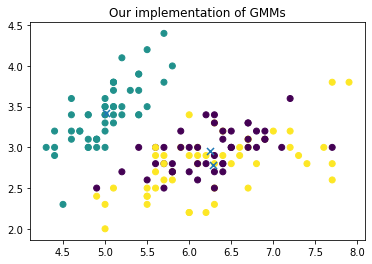

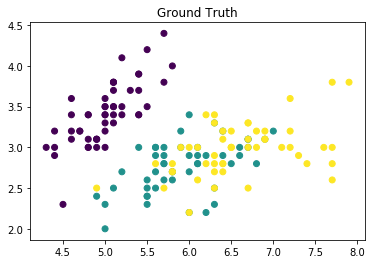

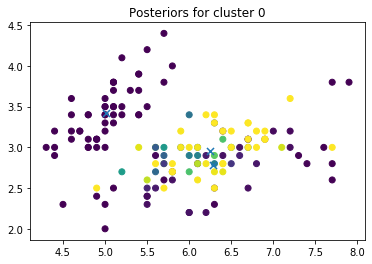

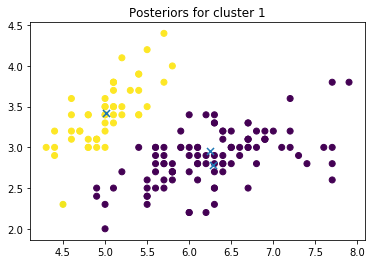

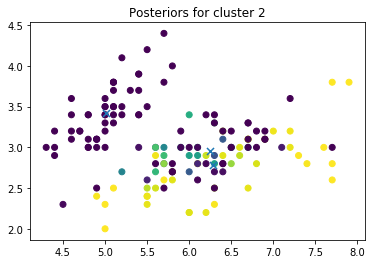

In [6]:
g = 3
n_iteration = 100

predicted_label, posteriors, centroids, cov, mix = gmm(data, g, n_iteration, 'print')

# Visualisation of model predictions
plt.scatter(data[:, x_feature], data[:, y_feature], c=predicted_label)
plt.scatter(centroids[:, x_feature], centroids[:, y_feature], s=50, marker='x')
plt.title('Our implementation of GMMs')
plt.show()

# Visualisation of ground truth
plt.scatter(data[:, x_feature], data[:, y_feature], c=labels)
plt.title('Ground Truth')
plt.show()

# Visualisation of model posteriors
for i_component in range(g):
    plt.scatter(data[:, x_feature], data[:, y_feature], c=posteriors[:, i_component])
    plt.scatter(centroids[:, x_feature], centroids[:, y_feature], s=50, marker='x')
    plt.title(f'Posteriors for cluster {i_component}')
    plt.show()